In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import quimb as qu
import quimb.tensor as qtn
import cotengra as ctg

opt = ctg.ReusableHyperOptimizer(
    reconf_opts={},
    max_repeats=16,
    parallel=True,
)

/home/ampolloreno/repos/cotengra/cotengra/hyper.py:29: UserWarning: Couldn't import `kahypar` - skipping from default hyper optimizer and using basic `labels` method instead.
  warnings.warn("Couldn't import `kahypar` - skipping from default "


In [70]:
from scipy.optimize import dual_annealing
from classical_optimization.qaoa_circuits import execute_qaoa_circuit_and_estimate_cost
import numpy as np
from qiskit import Aer, execute
from coldquanta.qiskit_tools.modeling.neutral_atom_noise_model import create_noise_model
import networkx as nx

np.random.seed(666)
reprate = 25 
one_hour = 60 * 60 #seconds
max_gamma = 2 * np.pi
max_beta = np.pi
simulator = Aer.get_backend('qasm_simulator')
noise_model = create_noise_model(cz_fidelity=1)

reg = 3
n = 20
seed = 666
graph = nx.watts_strogatz_graph(n, reg, .5, seed=seed)
# import numpy as np
# from networkx.algorithms.approximation.vertex_cover import min_weighted_vertex_cover
# n = 20
# p = 1/(n-1)
# g = nx.fast_gnp_random_graph(n, p, seed=2)

terms = {(i, j): np.random.rand() for i, j in graph.edges}
circ_ex = None
shots_per_point = 10
def weights(graph):
    rtn = {}
    for e in graph.edges:
        weight = graph.get_edge_data(e[0], e[1])['weight']
        rtn[e] = weight
    return rtn

def objective(graph):
    #Hack for backwards compatibility.
    num_rows = len(graph.nodes)
    num_cols = 1

    history = []
    def store_log(func):
        def logged_func(x):
            ret = func(x)
            history.append((x, ret))
            return ret
        return logged_func

    @store_log
    def gamma_beta_objective(gamma_beta):
        p=1
        gammas = [gamma_beta[1]]
        betas = [gamma_beta[0]]
        circ_ex = qtn.circ_qaoa(terms, p, gammas, betas)
        circ_ex = qtn.circuit_gen.circ_qaoa(terms, p, gammas, betas)
        ZZ = qu.pauli('Z') & qu.pauli('Z')
#         ens = [
#             circ_ex.local_expectation(weight * ZZ, edge, optimize=opt)
#             for edge, weight in terms.items()
#         ]
            
#         return sum(ens).real
        samples = list(circ_ex.simulate_counts(shots_per_point))
        values = []
        for sample in samples:
            value = 0
            for k, v in terms.items():
                if sample[k[0]] != sample[k[1]]:
                    value += 1
            values.append(value)
        return np.mean(values)
    return gamma_beta_objective, history



In [71]:
gammas = [1]
betas = [1]
p=1
# global circ_ex
# if circ_ex is None:
circ_ex = qtn.circuit_gen.circ_qaoa(terms, p, gammas, betas)
# else:
#     new_circ_ex = qtn.circuit_gen.circ_qaoa(terms, p, gammas, betas)
#     tm = new_circ_ex.to_dense_tn()
#     circ_ex.update_params_from(tm)
ZZ = qu.pauli('Z') & qu.pauli('Z')
ens = [
    circ_ex.local_expectation(weight * ZZ, edge, optimize=opt)
    for edge, weight in terms.items()
]

In [72]:
import networkx as nx
obj, hist = objective(graph)
all_data = []
bound = np.pi
samples = 20
for g in np.linspace(0, bound, num=samples):
    data = []
    print(g)
    for b in np.linspace(0, bound, num=samples):
        data.append(obj([b, g]))
    all_data.append(data)

0.0
0.16534698176788384
0.3306939635357677
0.4960409453036515
0.6613879270715354
0.8267349088394192
0.992081890607303
1.1574288723751869
1.3227758541430708
1.4881228359109546
1.6534698176788385
1.8188167994467224
1.984163781214606
2.14951076298249
2.3148577447503738
2.4802047265182576
2.6455517082861415
2.8108986900540254
2.9762456718219092
3.141592653589793


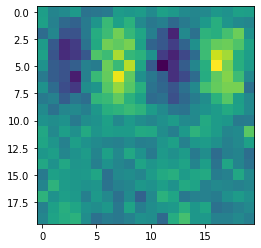

In [73]:
import matplotlib.pyplot as plt
plt.imshow(np.array(all_data))

In [74]:
from es import SimpleGA, CMAES, PEPG, OpenES
NPARAMS = 2
NPOPULATION = 10
oes = OpenES(NPARAMS,                  # number of model parameters
            sigma_init=0.025*np.pi*5,            # initial standard deviation
            sigma_decay=1,         # don't anneal standard deviation
            learning_rate=0.005,         # learning rate for standard deviation
            learning_rate_decay = 0.0, # annealing the learning rate
            popsize=NPOPULATION,       # population size
            antithetic=False,          # whether to use antithetic sampling
            weight_decay=0.00,         # weight decay coefficient
            rank_fitness=False,        # use rank rather than fitness numbers
            forget_best=True)

In [75]:
from tqdm import tqdm
MAX_ITERATION = 100
fit_func1, history = objective(graph)
fit_func = lambda x: fit_func1(x)
# defines a function to use solver to solve fit_func
def test_solver(solver):
    history = []
    for j in tqdm(range(MAX_ITERATION)):
        solutions = solver.ask()
        fitness_list = np.zeros(solver.popsize)
        for i in range(solver.popsize):
            fitness_list[i] = fit_func(solutions[i])
        solver.tell(fitness_list)
        result = solver.result() # first element is the best solution, second element is the best fitness
        print(result)
        history.append((result))
        if (j+1) % 100 == 0:
            print("fitness at iteration", (j+1), result[1])
    print("local optimum discovered by solver:\n", result[0])
    print("fitness score at this local optimum:", result[1])
    return history, result

In [76]:
history, result = test_solver(oes)


  1%|          | 1/100 [00:00<01:11,  1.39it/s]

(array([ 0.50866885, -0.20972406]), 11.5, 11.5, 0.39269908169872414)


  2%|▏         | 2/100 [00:01<01:07,  1.45it/s]

(array([ 0.49619168, -0.71369806]), 13.6, 13.6, 0.39269908169872414)


  3%|▎         | 3/100 [00:01<01:04,  1.50it/s]

(array([ 0.26377343, -0.72673404]), 12.8, 12.8, 0.39269908169872414)


  4%|▍         | 4/100 [00:02<01:02,  1.54it/s]

(array([0.03162753, 0.26822202]), 11.6, 11.6, 0.39269908169872414)


  5%|▌         | 5/100 [00:03<01:00,  1.56it/s]

(array([ 0.14106461, -0.56805307]), 12.4, 12.4, 0.39269908169872414)


  6%|▌         | 6/100 [00:03<00:59,  1.58it/s]

(array([ 0.46615006, -0.67443457]), 13.3, 13.3, 0.39269908169872414)


  7%|▋         | 7/100 [00:04<00:58,  1.60it/s]

(array([-0.46486484,  0.39074534]), 12.6, 12.6, 0.39269908169872414)


  8%|▊         | 8/100 [00:05<00:57,  1.60it/s]

(array([-0.03909002, -0.55694614]), 10.9, 10.9, 0.39269908169872414)


  9%|▉         | 9/100 [00:05<00:56,  1.61it/s]

(array([ 0.23723847, -0.02292328]), 11.6, 11.6, 0.39269908169872414)


 10%|█         | 10/100 [00:06<00:55,  1.62it/s]

(array([ 0.32304264, -0.2499342 ]), 11.9, 11.9, 0.39269908169872414)


 11%|█         | 11/100 [00:06<00:54,  1.63it/s]

(array([ 0.38463631, -1.13201191]), 13.4, 13.4, 0.39269908169872414)


 12%|█▏        | 12/100 [00:07<00:53,  1.64it/s]

(array([-0.24792524,  0.04760424]), 11.1, 11.1, 0.39269908169872414)


 13%|█▎        | 13/100 [00:08<00:53,  1.64it/s]

(array([-0.43162799,  0.64908938]), 15.0, 15.0, 0.39269908169872414)


 14%|█▍        | 14/100 [00:08<00:52,  1.64it/s]

(array([-0.32229238,  0.48075467]), 13.2, 13.2, 0.39269908169872414)


 15%|█▌        | 15/100 [00:09<00:51,  1.64it/s]

(array([ 0.25484711, -0.71522907]), 13.2, 13.2, 0.39269908169872414)


 16%|█▌        | 16/100 [00:09<00:51,  1.62it/s]

(array([ 0.30879289, -0.30723818]), 12.4, 12.4, 0.39269908169872414)


 17%|█▋        | 17/100 [00:10<00:50,  1.63it/s]

(array([-0.30706285,  0.72277525]), 12.8, 12.8, 0.39269908169872414)


 18%|█▊        | 18/100 [00:11<00:50,  1.62it/s]

(array([-0.1350504 ,  0.60360434]), 12.4, 12.4, 0.39269908169872414)


 19%|█▉        | 19/100 [00:11<00:49,  1.62it/s]

(array([-0.40892536,  0.80152976]), 14.4, 14.4, 0.39269908169872414)


 20%|██        | 20/100 [00:12<00:49,  1.62it/s]

(array([ 0.19162688, -0.2667054 ]), 11.1, 11.1, 0.39269908169872414)


 21%|██        | 21/100 [00:13<00:49,  1.60it/s]

(array([ 0.02748079, -0.00079609]), 11.5, 11.5, 0.39269908169872414)


 22%|██▏       | 22/100 [00:13<00:49,  1.59it/s]

(array([ 0.43058743, -0.19951821]), 12.6, 12.6, 0.39269908169872414)


 23%|██▎       | 23/100 [00:14<00:47,  1.60it/s]

(array([ 0.19884609, -0.14195191]), 11.5, 11.5, 0.39269908169872414)


 24%|██▍       | 24/100 [00:14<00:47,  1.62it/s]

(array([ 0.25943439, -0.37155496]), 13.3, 13.3, 0.39269908169872414)


 25%|██▌       | 25/100 [00:15<00:46,  1.61it/s]

(array([ 0.14508077, -0.14037835]), 11.7, 11.7, 0.39269908169872414)


 26%|██▌       | 26/100 [00:16<00:45,  1.61it/s]

(array([-0.38329103,  0.74666219]), 14.9, 14.9, 0.39269908169872414)


 27%|██▋       | 27/100 [00:16<00:44,  1.63it/s]

(array([-0.25340723,  0.22157786]), 12.0, 12.0, 0.39269908169872414)


 28%|██▊       | 28/100 [00:17<00:49,  1.45it/s]

(array([ 0.39274258, -0.63994692]), 13.7, 13.7, 0.39269908169872414)


 29%|██▉       | 29/100 [00:18<00:47,  1.50it/s]

(array([-0.42557544,  0.27711328]), 12.6, 12.6, 0.39269908169872414)


 30%|███       | 30/100 [00:18<00:45,  1.55it/s]

(array([-0.38106207,  0.31638553]), 12.7, 12.7, 0.39269908169872414)


 31%|███       | 31/100 [00:19<00:44,  1.55it/s]

(array([ 0.21824661, -0.36839602]), 11.2, 11.2, 0.39269908169872414)


 32%|███▏      | 32/100 [00:20<00:43,  1.57it/s]

(array([-0.39895599,  0.85030507]), 13.4, 13.4, 0.39269908169872414)


 33%|███▎      | 33/100 [00:20<00:42,  1.59it/s]

(array([ 0.43394627, -0.43876536]), 13.1, 13.1, 0.39269908169872414)


 34%|███▍      | 34/100 [00:21<00:41,  1.61it/s]

(array([-0.42698467,  0.29018061]), 13.3, 13.3, 0.39269908169872414)


 35%|███▌      | 35/100 [00:21<00:40,  1.61it/s]

(array([ 0.17616808, -0.78426701]), 12.4, 12.4, 0.39269908169872414)


 36%|███▌      | 36/100 [00:22<00:39,  1.62it/s]

(array([-0.1256362 ,  0.18908683]), 11.6, 11.6, 0.39269908169872414)


 37%|███▋      | 37/100 [00:23<00:38,  1.62it/s]

(array([-0.5028815,  0.771304 ]), 12.9, 12.9, 0.39269908169872414)


 38%|███▊      | 38/100 [00:23<00:38,  1.63it/s]

(array([ 0.28946016, -0.70081113]), 13.5, 13.5, 0.39269908169872414)


 39%|███▉      | 39/100 [00:24<00:37,  1.63it/s]

(array([ 0.37152288, -0.66302794]), 14.1, 14.1, 0.39269908169872414)


 40%|████      | 40/100 [00:24<00:36,  1.63it/s]

(array([ 0.20114024, -0.47045137]), 12.0, 12.0, 0.39269908169872414)


 41%|████      | 41/100 [00:25<00:36,  1.63it/s]

(array([-0.38902206,  0.69633089]), 14.5, 14.5, 0.39269908169872414)


 42%|████▏     | 42/100 [00:26<00:35,  1.64it/s]

(array([ 0.51371189, -0.55432778]), 13.8, 13.8, 0.39269908169872414)


 43%|████▎     | 43/100 [00:26<00:34,  1.64it/s]

(array([ 0.57410275, -0.42528828]), 12.4, 12.4, 0.39269908169872414)


 44%|████▍     | 44/100 [00:27<00:34,  1.64it/s]

(array([-0.39623132,  0.55172419]), 15.0, 15.0, 0.39269908169872414)


 45%|████▌     | 45/100 [00:27<00:33,  1.64it/s]

(array([ 0.25261406, -0.10856962]), 11.7, 11.7, 0.39269908169872414)


 46%|████▌     | 46/100 [00:28<00:32,  1.64it/s]

(array([ 0.11171492, -0.33220605]), 13.3, 13.3, 0.39269908169872414)


 47%|████▋     | 47/100 [00:29<00:32,  1.63it/s]

(array([-0.43962979,  0.64520076]), 13.2, 13.2, 0.39269908169872414)


 48%|████▊     | 48/100 [00:29<00:31,  1.64it/s]

(array([-0.20977184,  0.6871904 ]), 12.8, 12.8, 0.39269908169872414)


 49%|████▉     | 49/100 [00:30<00:31,  1.63it/s]

(array([ 0.34893993, -0.87821313]), 13.7, 13.7, 0.39269908169872414)


 50%|█████     | 50/100 [00:31<00:30,  1.62it/s]

(array([-0.33053387,  0.14242574]), 12.8, 12.8, 0.39269908169872414)


 51%|█████     | 51/100 [00:31<00:30,  1.63it/s]

(array([-0.38684533,  0.27525342]), 11.2, 11.2, 0.39269908169872414)


 52%|█████▏    | 52/100 [00:32<00:29,  1.63it/s]

(array([-0.60838665,  0.86539728]), 13.9, 13.9, 0.39269908169872414)


 53%|█████▎    | 53/100 [00:32<00:28,  1.63it/s]

(array([-0.43948704,  0.14505263]), 12.4, 12.4, 0.39269908169872414)


 54%|█████▍    | 54/100 [00:33<00:28,  1.64it/s]

(array([-0.24204705,  0.57907572]), 13.2, 13.2, 0.39269908169872414)


 55%|█████▌    | 55/100 [00:34<00:27,  1.62it/s]

(array([ 0.28617086, -0.49816706]), 13.9, 13.9, 0.39269908169872414)


 56%|█████▌    | 56/100 [00:34<00:27,  1.63it/s]

(array([-0.22624717,  0.51735674]), 12.7, 12.7, 0.39269908169872414)


 57%|█████▋    | 57/100 [00:35<00:26,  1.63it/s]

(array([ 0.15177435, -0.5566641 ]), 11.7, 11.7, 0.39269908169872414)


 58%|█████▊    | 58/100 [00:35<00:26,  1.61it/s]

(array([ 0.32057553, -0.53948884]), 13.7, 13.7, 0.39269908169872414)


 59%|█████▉    | 59/100 [00:36<00:25,  1.63it/s]

(array([ 0.5765028 , -0.55113412]), 13.8, 13.8, 0.39269908169872414)


 60%|██████    | 60/100 [00:37<00:24,  1.62it/s]

(array([-0.79343921, -0.23766998]), 11.1, 11.1, 0.39269908169872414)


 61%|██████    | 61/100 [00:37<00:24,  1.62it/s]

(array([-0.15087978,  0.27874169]), 11.3, 11.3, 0.39269908169872414)


 62%|██████▏   | 62/100 [00:38<00:23,  1.62it/s]

(array([ 0.28675566, -0.11812972]), 12.0, 12.0, 0.39269908169872414)


 63%|██████▎   | 63/100 [00:39<00:22,  1.63it/s]

(array([-0.27906726,  0.57596002]), 14.4, 14.4, 0.39269908169872414)


 64%|██████▍   | 64/100 [00:39<00:22,  1.61it/s]

(array([ 0.43648469, -0.84636929]), 13.3, 13.3, 0.39269908169872414)


 65%|██████▌   | 65/100 [00:40<00:21,  1.60it/s]

(array([-0.44308141,  0.82030158]), 13.4, 13.4, 0.39269908169872414)


 66%|██████▌   | 66/100 [00:40<00:21,  1.59it/s]

(array([ 0.579857  , -0.30048115]), 11.8, 11.8, 0.39269908169872414)


 67%|██████▋   | 67/100 [00:41<00:20,  1.61it/s]

(array([ 0.30589121, -0.56540264]), 13.0, 13.0, 0.39269908169872414)


 68%|██████▊   | 68/100 [00:42<00:19,  1.61it/s]

(array([-0.28392624,  0.24606839]), 13.1, 13.1, 0.39269908169872414)


 69%|██████▉   | 69/100 [00:42<00:19,  1.60it/s]

(array([ 0.1721816 , -0.55274526]), 12.6, 12.6, 0.39269908169872414)


 70%|███████   | 70/100 [00:43<00:18,  1.61it/s]

(array([-0.34347971,  0.212735  ]), 12.2, 12.2, 0.39269908169872414)


 71%|███████   | 71/100 [00:44<00:18,  1.59it/s]

(array([ 0.30705349, -0.65646383]), 12.9, 12.9, 0.39269908169872414)


 72%|███████▏  | 72/100 [00:44<00:17,  1.58it/s]

(array([ 0.5045865, -0.9750914]), 13.3, 13.3, 0.39269908169872414)


 73%|███████▎  | 73/100 [00:45<00:18,  1.47it/s]

(array([-0.57302352,  0.53951973]), 13.0, 13.0, 0.39269908169872414)


 74%|███████▍  | 74/100 [00:46<00:17,  1.47it/s]

(array([ 0.22928105, -0.31999756]), 13.2, 13.2, 0.39269908169872414)


 75%|███████▌  | 75/100 [00:46<00:17,  1.45it/s]

(array([ 0.2745868, -0.8684709]), 13.1, 13.1, 0.39269908169872414)


 76%|███████▌  | 76/100 [00:47<00:16,  1.48it/s]

(array([ 0.32284767, -0.24606825]), 11.7, 11.7, 0.39269908169872414)


 77%|███████▋  | 77/100 [00:48<00:15,  1.51it/s]

(array([ 0.19373215, -0.74626065]), 12.5, 12.5, 0.39269908169872414)


 78%|███████▊  | 78/100 [00:48<00:14,  1.50it/s]

(array([ 0.40825672, -0.66688317]), 12.9, 12.9, 0.39269908169872414)


 79%|███████▉  | 79/100 [00:49<00:14,  1.49it/s]

(array([-0.11762252,  0.5069733 ]), 12.3, 12.3, 0.39269908169872414)


 80%|████████  | 80/100 [00:50<00:13,  1.46it/s]

(array([ 0.6931103 , -0.61328742]), 12.5, 12.5, 0.39269908169872414)


 81%|████████  | 81/100 [00:51<00:13,  1.38it/s]

(array([ 0.30243183, -0.3707134 ]), 12.6, 12.6, 0.39269908169872414)


 82%|████████▏ | 82/100 [00:51<00:13,  1.34it/s]

(array([ 0.29715525, -0.2711979 ]), 12.5, 12.5, 0.39269908169872414)


 83%|████████▎ | 83/100 [00:52<00:12,  1.41it/s]

(array([-0.40489954,  0.40577364]), 13.5, 13.5, 0.39269908169872414)


 84%|████████▍ | 84/100 [00:53<00:11,  1.40it/s]

(array([-0.45668928,  0.58550838]), 14.0, 14.0, 0.39269908169872414)


 85%|████████▌ | 85/100 [00:54<00:11,  1.30it/s]

(array([ 0.4236109, -0.4558411]), 13.9, 13.9, 0.39269908169872414)


 86%|████████▌ | 86/100 [00:55<00:11,  1.22it/s]

(array([-0.26944516,  0.63539402]), 14.0, 14.0, 0.39269908169872414)


 87%|████████▋ | 87/100 [00:55<00:10,  1.22it/s]

(array([ 0.31758163, -0.34635195]), 12.4, 12.4, 0.39269908169872414)


 88%|████████▊ | 88/100 [00:56<00:09,  1.24it/s]

(array([ 0.43718349, -0.74420472]), 13.7, 13.7, 0.39269908169872414)


 89%|████████▉ | 89/100 [00:57<00:08,  1.24it/s]

(array([-0.44569406,  0.42902027]), 12.7, 12.7, 0.39269908169872414)


 90%|█████████ | 90/100 [00:58<00:07,  1.28it/s]

(array([-0.50399646,  0.34867904]), 13.1, 13.1, 0.39269908169872414)


 91%|█████████ | 91/100 [00:58<00:06,  1.30it/s]

(array([-0.41826473,  0.29146341]), 13.1, 13.1, 0.39269908169872414)


 92%|█████████▏| 92/100 [00:59<00:06,  1.27it/s]

(array([-0.44148001,  0.59669587]), 14.1, 14.1, 0.39269908169872414)


 93%|█████████▎| 93/100 [01:00<00:05,  1.23it/s]

(array([-0.29514028,  0.81731265]), 13.9, 13.9, 0.39269908169872414)


 94%|█████████▍| 94/100 [01:01<00:04,  1.30it/s]

(array([ 0.51282274, -0.42988423]), 12.9, 12.9, 0.39269908169872414)


 95%|█████████▌| 95/100 [01:01<00:03,  1.36it/s]

(array([-0.11454562,  0.34246093]), 10.7, 10.7, 0.39269908169872414)


 96%|█████████▌| 96/100 [01:02<00:02,  1.40it/s]

(array([-0.9064041 , -0.58707952]), 12.1, 12.1, 0.39269908169872414)


 97%|█████████▋| 97/100 [01:03<00:02,  1.44it/s]

(array([-0.17191792,  0.43410995]), 13.0, 13.0, 0.39269908169872414)


 98%|█████████▊| 98/100 [01:03<00:01,  1.44it/s]

(array([-0.31638807,  0.21231393]), 12.6, 12.6, 0.39269908169872414)


 99%|█████████▉| 99/100 [01:04<00:00,  1.47it/s]

(array([-0.18219052,  0.35495593]), 11.6, 11.6, 0.39269908169872414)


100%|██████████| 100/100 [01:05<00:00,  1.53it/s]

(array([-0.50501003,  0.84314838]), 14.8, 14.8, 0.39269908169872414)
fitness at iteration 100 14.8
local optimum discovered by solver:
 [-0.50501003  0.84314838]
fitness score at this local optimum: 14.8


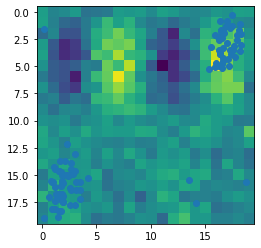

In [77]:
plt.imshow(all_data)
xys = [h[0] for h in history]
x = [el[0]%(bound)*(samples-1)/(bound) for el in xys]
y = [el[1]%(bound)*(samples-1)/(bound) for el in xys]
plt.scatter(x, y)

In [78]:
# It's currently reporting the average fitness, which of course it might want to use when it's estimating the energy
# But at the end it should report the maximum value. Here the mean is 10.1, which suggests that a better bitstring was 
# sampled.

# Annealing

In [79]:
from tqdm import tqdm
annealing_attempts = []
func, history2 = objective(graph)
np.random.seed(seed)
initial_gamma_beta = [np.random.rand() * max_param for max_param in (max_gamma, max_beta)]
result = dual_annealing(
    lambda x: -1*func(x),
    bounds=[(0, max_gamma),
            (0, max_beta)],
    x0=np.array(initial_gamma_beta),
    # One annealing attempt.
    maxiter=10,
    maxfun=one_hour*reprate,
    seed=1)
result.fun = -result.fun
(result.x, result.fun)        

(array([1.06185622, 0.38259266]), 13.2)

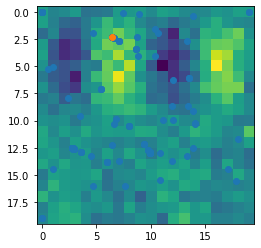

In [80]:
xys2 = [h[0] for h in history2]
x2 = [el[0]%(bound)*(samples-1)/(bound) for el in xys2]
y2 = [el[1]%(bound)*(samples-1)/(bound) for el in xys2]
plt.scatter(x2,y2)
plt.scatter([result.x[0]%(bound)*(samples-1)/(bound)], [result.x[1]%(bound)*(samples-1)/(bound)])
plt.imshow(all_data)